In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torchvision.transforms as transforms

In [ ]:
data_path = '../datasets/celeba_data'
workers = 2
img_size = 64
batch_size = 128

# number of channels and latent size
nc = 3
nz = 100

# feature map sizes (generator and discriminator)
ngf = 64
ndf = 64

num_epochs = 5
lr_d = 5e-4
lr_g = 2e-4
beta1 = 0.5

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5)
        )
    ])
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [5]:
print('using device', device)

using device cuda


In [6]:
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [9]:
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))

def get_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, 1, 1, device=device)

In [ ]:
os.makedirs('./celeba_dcgan_results', exist_ok=True)
loss_d_list, loss_g_list = [], []

for epoch in range(num_epochs):
    total_loss_d, total_loss_g = 0, 0
    for i, (images, _) in tqdm(enumerate(dataloader), total=len(dataloader)):

        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        discriminator.zero_grad()
        outputs = discriminator(images.to(device)).view(-1, 1)
        loss_d_real = criterion(outputs, real_labels)
        loss_d_real.backward()
        
        z = get_noise(batch_size, nz)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach()).view(-1, 1)
        loss_d_fake = criterion(outputs, fake_labels)
        loss_d_fake.backward()
        
        loss_d = loss_d_fake + loss_d_real
        optimizer_d.step()
        
        generator.zero_grad()
        outputs = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(outputs, real_labels)
        loss_g.backward()
        optimizer_g.step()
        
        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
    
    total_loss_d /= len(dataloader)
    total_loss_g /= len(dataloader)
    loss_d_list.append(total_loss_d)
    loss_g_list.append(total_loss_g)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    fake_images = fake_images.reshape(batch_size, 3, img_size, img_size)
    vutils.save_image(fake_images, f'./celeba_dcgan_results/fake_celeba_results{epoch+1}.png', normalize=True)
        

100%|██████████| 1583/1583 [06:23<00:00,  4.13it/s]


Epoch [1/5], Loss D: 0.7067, Loss G: 6.2190


100%|██████████| 1583/1583 [10:54<00:00,  2.42it/s]


Epoch [2/5], Loss D: 0.3328, Loss G: 3.2487


100%|██████████| 1583/1583 [13:06<00:00,  2.01it/s]


Epoch [3/5], Loss D: 0.6215, Loss G: 3.8114


100%|██████████| 1583/1583 [13:27<00:00,  1.96it/s]


Epoch [4/5], Loss D: 0.5407, Loss G: 2.6162


100%|██████████| 1583/1583 [13:19<00:00,  1.98it/s]


Epoch [5/5], Loss D: 0.3160, Loss G: 3.2605


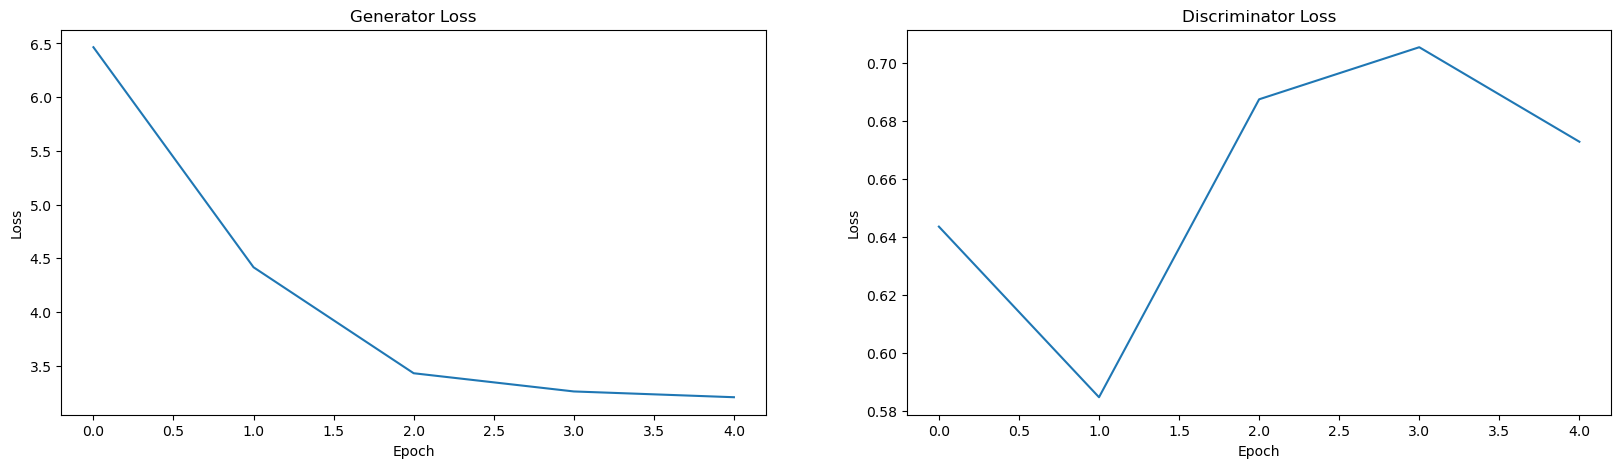

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title('Generator Loss')
axs[0].plot(loss_g_list)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_title('Discriminator Loss')
axs[1].plot(loss_d_list)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.show()